In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd

In [2]:
transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
    ]
)

In [3]:
train_dataset = torchvision.datasets.ImageFolder(
    '/home/vlad/нейронки/images/TRAIN',
    transform=transform
)
valid_dataset = torchvision.datasets.ImageFolder(
    '/home/vlad/нейронки/images/TEST',
    transform=transform
)


In [4]:
train_dataset


Dataset ImageFolder
    Number of datapoints: 9957
    Root location: /home/vlad/нейронки/images/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomPerspective(p=0.5)
           )

In [5]:

train_dataset.class_to_idx     


{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [6]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [7]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [8]:
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(valid_dataset)}")

Размер обучающей выборки: 9957
Размер валидационной выборки: 2487


In [9]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

cpu


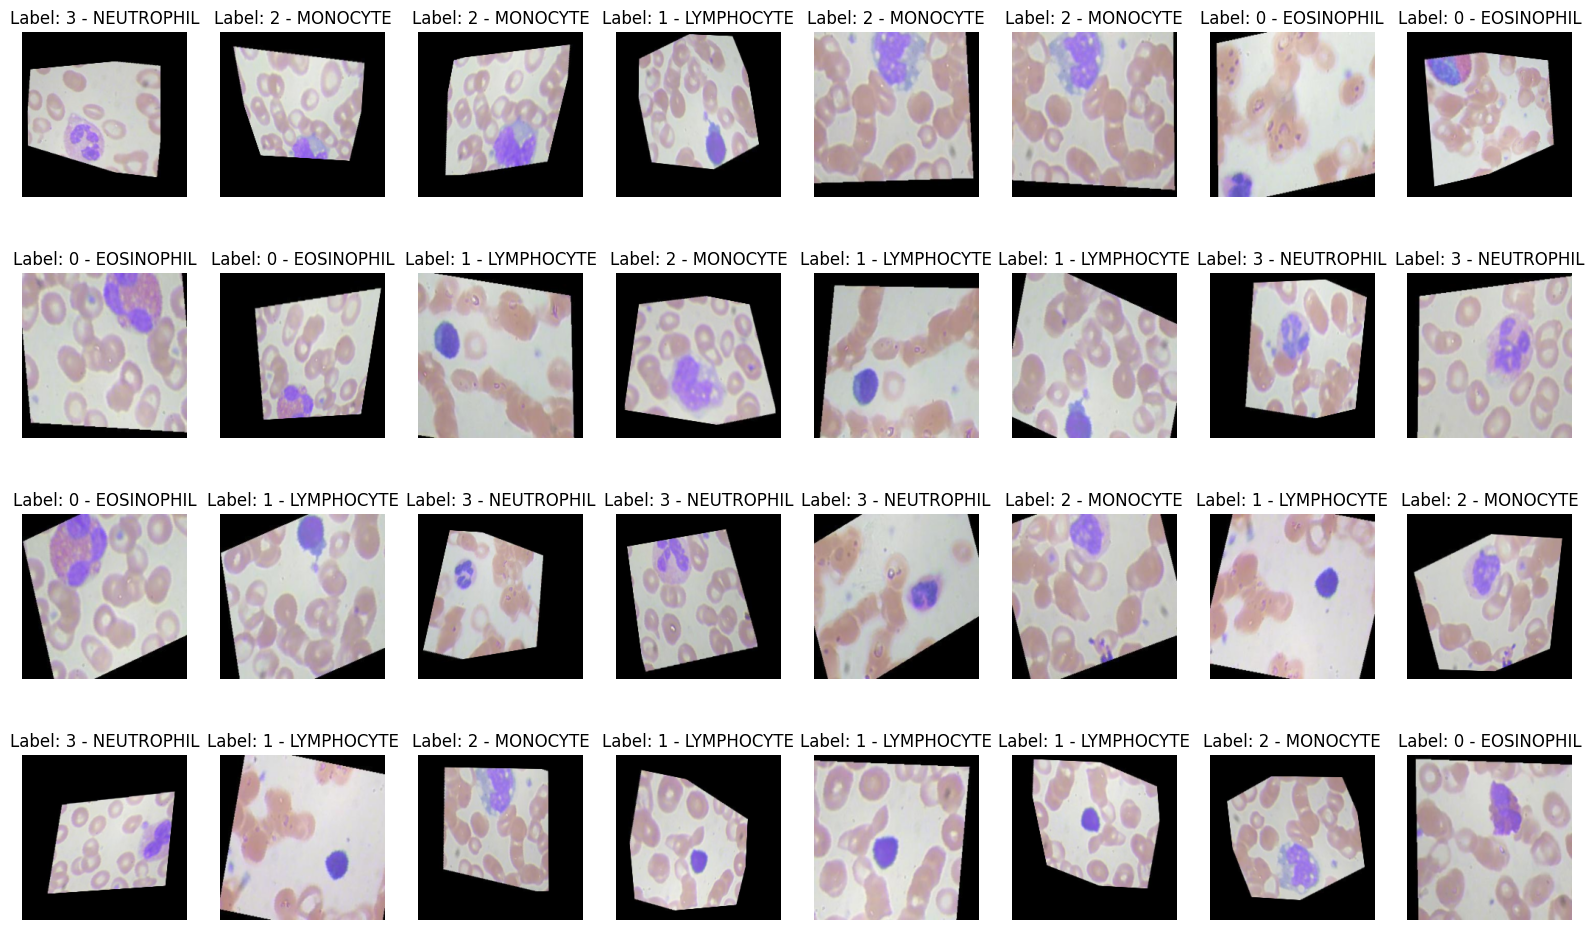

In [10]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [11]:
def fit(
    model: torch.nn.Module,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple[list, ...]:
    """
    Function to fit model.
    Returns:
        train_losses: list of train losses per epoch
        valid_losses: list of valid losses per epoch
        train_acc: list of train accuracy per epoch
        valid_acc: list of valid accuracy per epoch
    """
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(n_epochs):
        # Обучающий шаг
        model.train()  # Режим обучения
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            # Перемещаем данные на устройство
            images = images.to(device)
            labels = labels.to(device)

            # Преобразуем метки в long, если они не являются такими
            if labels.dtype != torch.int64:
                labels = labels.long()

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Собираем статистику
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Сохраняем среднюю потерю и точность на тренировке
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        # Валидационный шаг
        model.eval()  # Режим оценки
        running_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # Отключаем вычисление градиентов
            for images, labels in valid_loader:
                # Перемещаем данные на устройство
                images = images.to(device)
                labels = labels.to(device)

                # Преобразуем метки в long, если они не являются такими
                if labels.dtype != torch.int64:
                    labels = labels.long()

                # Прямой проход
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Собираем статистику
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        # Сохраняем среднюю потерю и точность на валидации
        valid_losses.append(running_loss / len(valid_loader))
        valid_acc.append(correct_valid / total_valid)

        # Выводим прогресс
        print(f"Epoch [{epoch + 1}/{n_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_acc[-1]:.4f}")

    return train_losses, valid_losses, train_acc, valid_acc

In [12]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)


In [13]:
tu.get_model_summary(model.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                         Kernel              Output          Params           FLOPs
0_conv1                                      [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                                 [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                   -   [1, 64, 112, 112]           0             0
3_maxpool                                                -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 56, 56]       4,096    12,845,056
5_layer1.0.BatchNorm2d_bn1                            [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                     -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                            [

In [14]:
model.fc
model.fc = nn.Linear(512, 4)

In [28]:
for param in model.parameters():
    param.requires_grad = False

In [29]:
# Разморозка layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# Разморозка fc
for param in model.fc.parameters():
    param.requires_grad = True

In [30]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Тренируемый параметр: {name}")

Тренируемый параметр: layer4.0.conv1.weight
Тренируемый параметр: layer4.0.bn1.weight
Тренируемый параметр: layer4.0.bn1.bias
Тренируемый параметр: layer4.0.conv2.weight
Тренируемый параметр: layer4.0.bn2.weight
Тренируемый параметр: layer4.0.bn2.bias
Тренируемый параметр: layer4.0.conv3.weight
Тренируемый параметр: layer4.0.bn3.weight
Тренируемый параметр: layer4.0.bn3.bias
Тренируемый параметр: layer4.0.downsample.0.weight
Тренируемый параметр: layer4.0.downsample.1.weight
Тренируемый параметр: layer4.0.downsample.1.bias
Тренируемый параметр: layer4.1.conv1.weight
Тренируемый параметр: layer4.1.bn1.weight
Тренируемый параметр: layer4.1.bn1.bias
Тренируемый параметр: layer4.1.conv2.weight
Тренируемый параметр: layer4.1.bn2.weight
Тренируемый параметр: layer4.1.bn2.bias
Тренируемый параметр: layer4.1.conv3.weight
Тренируемый параметр: layer4.1.bn3.weight
Тренируемый параметр: layer4.1.bn3.bias
Тренируемый параметр: layer4.2.conv1.weight
Тренируемый параметр: layer4.2.bn1.weight
Трениру

In [33]:
optima = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [34]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
import datetime
start = datetime.datetime.now()
print('Время старта: ' + str(start))

# Перемещаем модель на устройство
model.to(device)

# Обучение модели с использованием функции fit
train_losses, valid_losses, train_acc, valid_acc = fit(
    model=model,
    n_epochs=10,
    optimizer=optima,  
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    device=device
)

# Замер времени окончания обучения
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# Вычисление общего времени обучения
elapsed_time = finish - start
print('Время обучения: ' + str(elapsed_time))

Время старта: 2025-02-07 12:41:12.518387
Epoch [1/10], Train Loss: 0.3400, Train Acc: 0.8613, Valid Loss: 0.8812, Valid Acc: 0.7358
Epoch [2/10], Train Loss: 0.0999, Train Acc: 0.9628, Valid Loss: 0.8828, Valid Acc: 0.7909
Epoch [3/10], Train Loss: 0.0656, Train Acc: 0.9767, Valid Loss: 0.7971, Valid Acc: 0.8034
Epoch [4/10], Train Loss: 0.0509, Train Acc: 0.9817, Valid Loss: 1.4065, Valid Acc: 0.7386


KeyboardInterrupt: 

In [49]:
#torch.save(model.state_dict, '/home/vlad/нейронки/models/model_weights.pth')

In [ ]:
data_metrics = np.array([
    train_losses, 
    valid_losses, 
    train_acc, 
    valid_acc
]).T  


time_elapsed = [elapsed_time.total_seconds()] * len(train_losses)  # Создаем список с одинаковым временем для каждой эпохи
data_metrics = np.column_stack((data_metrics, time_elapsed))  # Объединяем массивы


df = pd.DataFrame(data_metrics, columns=['train_losses', 'valid_losses', 'train_metric', 'valid_metric', 'time'])


print(df)

In [ ]:
#df.to_csv('/home/vlad/нейронки/models/data.csv', index=False, encoding='utf-8')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# График потерь
ax[0].plot(train_losses, label="Train Loss", color="blue")
ax[0].plot(valid_losses, label="Valid Loss", color="orange")
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# График точности
ax[1].plot(train_acc, label="Train Accuracy", color="blue")
ax[1].plot(valid_acc, label="Valid Accuracy", color="orange")
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten() # переводим в одномерный массив
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()  # Получаем индекс метки из тестового набора
    y_pred = torch.argmax(model(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'g'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    plot.imshow(img.cpu())#plot.matshow(test_samples[i][0, :, :].cpu().detach().numpy(), cmap='gray')
    plot.axis('off')